## Imports

In [11]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "torch" # needs to be imported before
import keras_core as keras
from keras_core import layers
from keras_core import ops
import shutil
from PIL import Image
import keras_cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Organize Dataset

In [2]:
os.mkdir("face_direction_dataset")
for direction in ["left", "right", "up", "straight"]:
    os.mkdir(f"face_direction_dataset/{direction}")

FileExistsError: [Errno 17] File exists: 'face_direction_dataset'

In [ ]:
for person_folder in os.listdir("faces"):
    if not person_folder.startswith("."):
        for image_filename in os.listdir(os.path.join("faces", person_folder)):
            tags = image_filename[:-4].split("_")
            if len(tags) == 4:
                label = tags[1] # direction face is pointing towards
                origin_path = os.path.join("faces", person_folder, image_filename)
                new_image_filename = "{}.png".format(image_filename[:-4])
                destination_path = os.path.join("face_direction_dataset", label, new_image_filename)
                if image_filename[-4:] == ".pgm":
                    with Image.open(origin_path) as im:
                        im.save(destination_path)

## Load Data

In [3]:
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    directory='face_direction_dataset/',
    labels="inferred",
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="both",
    seed=0
)

Found 624 files belonging to 4 classes.
Using 500 files for training.
Using 124 files for validation.


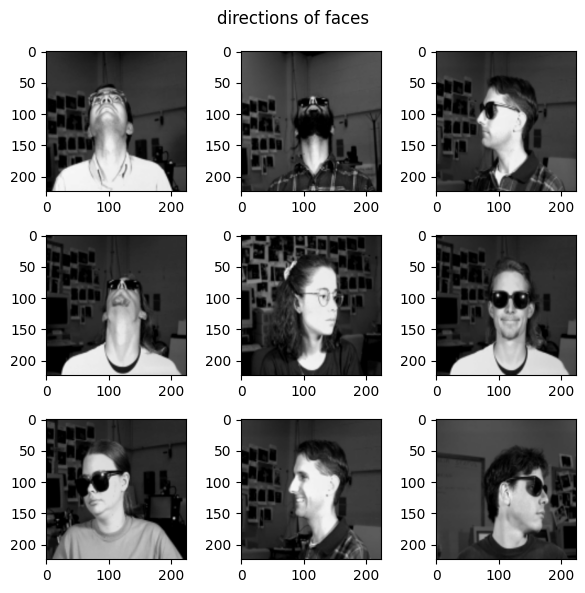

In [4]:
def plot_image_grid(images, grid=3, title=None):
    fig, axes = plt.subplots(grid,grid, figsize=(grid*2,grid*2))
    for i in range(grid):
        for j in range(grid):
            if i*grid + j < len(images):
                axes[i][j].imshow(images[i*grid + j].astype('uint8'))
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    
X = np.concatenate([x for x, y in train_dataset], axis=0)
plot_image_grid(X, title="directions of faces")

## Load Classification Model

In [5]:
resnet = keras.applications.ResNet50(weights="imagenet", include_top=False)
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │       0 │ -                    │
│ (InputLayer)        │ None, 3)          │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_pad           │ (None, None,      │       0 │ input_layer[0][0]    │
│ (ZeroPadding2D)     │ None, 3)          │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │   9,472 │ conv1_pad[0][0]      │
│                     │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_bn            │ (None, None,      │     256 │ conv1_conv[0][0]     │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_relu          │ (None, None,      │       0 │ conv1_bn[0][0]       │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pad           │ (None, None,      │       0 │ conv1_relu[0][0]     │
│ (ZeroPadding2D)     │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pool          │ (None, None,      │       0 │ pool1_pad[0][0]      │
│ (MaxPooling2D)      │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_conv │ (None, None,      │   4,160 │ pool1_pool[0][0]     │
│ (Conv2D)            │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │     256 │ conv2_block1_1_conv… │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_relu │ (None, None,      │       0 │ conv2_block1_1_bn[0… │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_conv │ (None, None,      │  36,928 │ conv2_block1_1_relu… │
│ (Conv2D)            │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │     256 │ conv2_block1_2_conv… │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_relu │ (None, None,      │       0 │ conv2_block1_2_bn[0… │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_conv │ (None, None,      │  16,640 │ pool1_pool[0][0]     │
│ (Conv2D)            │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_conv │ (None, None,      │  16,640 │ conv2_block1_2_relu… │
│ (Conv2D)            │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │   1,024 │ conv2_block1_0_conv… │
│ (BatchNormalizatio… │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │   1,024 │ conv2_block1_3_conv

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Build Transfer Learning Model
- Use the functional API for more flexibility. Previously we used the sequential way.

In [6]:
inputs = keras.Input(shape=(224, 224, 3))
x = resnet(inputs, training=False)
x = keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)        │ 23,587,712 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 16)          │    294,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 16)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 4)                 │         68 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 23,882,708 (91.11 MB)

 Trainable params: 23,829,588 (90.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train Model

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - accuracy: 0.3234 - loss: 1.5501 - val_accuracy: 0.4919 - val_loss: 1.2307
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 149s 9s/step - accuracy: 0.8725 - loss: 0.6761 - val_accuracy: 0.5565 - val_loss: 0.8973
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - accuracy: 0.9966 - loss: 0.2970 - val_accuracy: 0.7984 - val_loss: 0.4580
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 455s 30s/step - accuracy: 0.9984 - loss: 0.1135 - val_accuracy: 0.8871 - val_loss: 0.2778
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1073s 71s/step - accuracy: 0.9987 - loss: 0.0533 - val_accuracy: 0.9274 - val_loss: 0.1894


In [9]:
history_df = pd.DataFrame(history.history)
history_df.head(3)

,accuracy,loss,val_accuracy,val_loss
0,0.418,1.354461,0.491935,1.230722
1,0.914,0.599083,0.556452,0.897270
2,0.996,0.246551,0.798387,0.457953


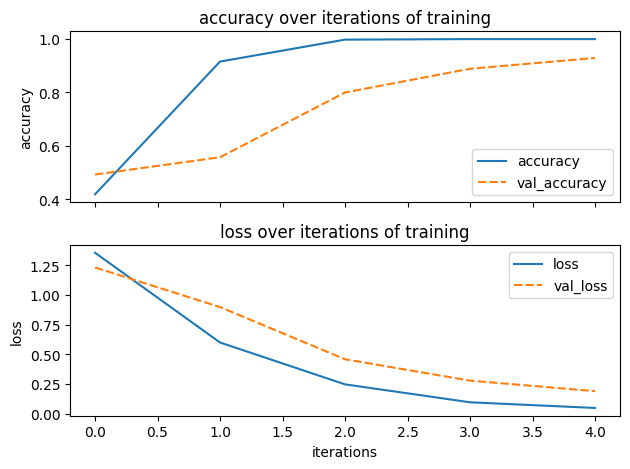

In [10]:
# Helper function to plot accuracy and loss of the run
def plot_history(history_df):
    fig, axes = plt.subplots(2,1, sharex=True)
    sns.lineplot(data=history_df[["accuracy", "val_accuracy"]], ax=axes[0]).set(
        title="accuracy over iterations of training",
        xlabel="iterations",
        ylabel="accuracy"
    )
    sns.lineplot(data=history_df[["loss", "val_loss"]], ax=axes[1]).set(
        title="loss over iterations of training",
        xlabel="iterations",
        ylabel="loss"
    )
    plt.tight_layout()
plot_history(history_df)

## Analyze the Model

In [13]:
labels = sorted(["left", "right", "up", "straight"])

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


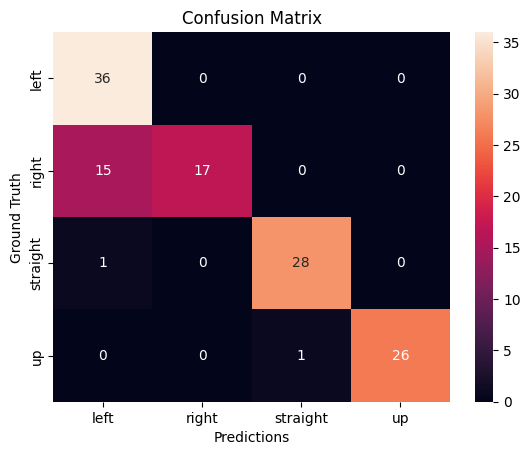

In [14]:
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)))
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            matrix[i][j] = np.count_nonzero((y_true == label_true) & (y_pred == label_pred))
    return matrix

def get_confusion_matrix(model, dataset):
    y_true = np.argmax(np.concatenate([y for x, y in dataset], axis=0), axis=1)
    y_pred = np.argmax(model.predict(dataset), axis=1)
    confusion_mat = confusion_matrix(y_true, y_pred)
    confusion_df = pd.DataFrame(confusion_mat, columns=labels, index=labels)
    sns.heatmap(confusion_df, annot=True).set(
        title="Confusion Matrix",
        xlabel="Predictions",
        ylabel="Ground Truth"
    )
get_confusion_matrix(model, validation_dataset)

In [16]:
y_true = np.argmax(np.concatenate([y for x, y in validation_dataset], axis=0), axis=1)
X = np.concatenate([x for x, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)
predictions = list(zip(X, y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


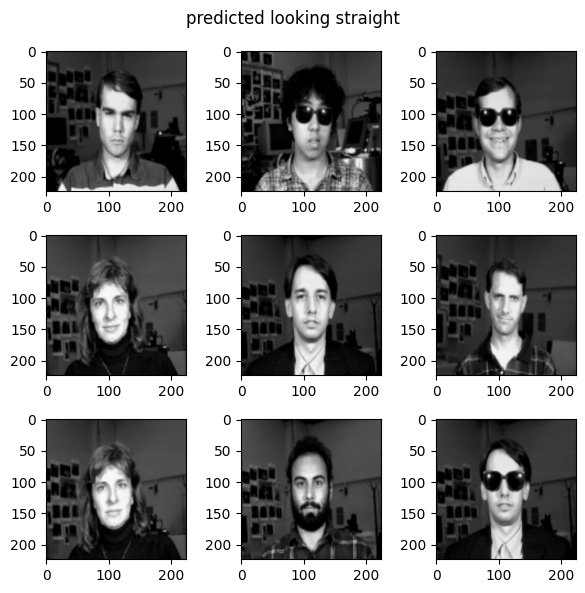

In [21]:
predictions1 = [image for image, y_true, y_pred in predictions if y_pred == 2]
plot_image_grid(predictions1, grid=3, title="predicted looking straight")

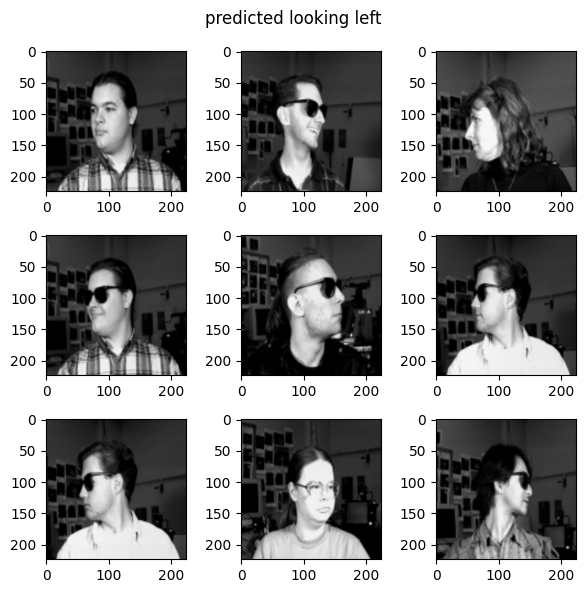

In [20]:
predictions1 = [image for image, y_true, y_pred in predictions if y_pred == 0]
plot_image_grid(predictions1, grid=3, title="predicted looking left")

In [ ]:
predictions1 = [image for image, y_true, y_pred in predictions if y_pred == 0]
plot_image_grid(predictions1, grid=3, title="predicted looking up")